# 데이터 y 값 불러와서 match 해야함 

In [4]:
import tensorflow
from keras import layers, Sequential, backend
from keras.layers import Dense,Flatten,Conv2D,AveragePooling2D,MaxPool2D
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import pandas as pd

Using TensorFlow backend.


In [5]:

def ExtractImage(path):
    img_l=[]
    img_name=[]
    path= path+'*1800.png'  # 이미지 타입고르기 : 시간조정 

    for filename in glob.iglob(path, recursive=True):
        temp_img = cv2.imread(filename)
        img_l.append(temp_img)
        filename=filename[-16:-6]  # y값과 일치시키기 위해 필요한 joinkey의 뒷자리만큼 자르기 
        img_name.append(filename)
    return img_l,img_name


def extractRadiation(y_path,img_name):
    csvfile=pd.read_csv(y_path,encoding='cp949') # utf-8  or  cp949
    filtered_csv=[]
    for i in list(range(0,len(img_name))): #img의 날짜를 str ->int 필요함
        temp=csvfile.loc[csvfile['일시']==int(img_name[i]),['일사(MJ/m2)']]
        temp=temp.values.tolist()
        filtered_csv.append(temp)
    return filtered_csv


def imgtoRGB(img_l,STN_List):
    data_set3=[]  
    for i in list(range(0,len(img_l))):       
        img=img_l[i]  # 사진의 길이만큼 data_set2 tensor를 저장 


        data_set2=[] # 두개 채널의 rgb tensor
        for k in STN_List :  # 한개의 이미지에 대하여 23개 관측소x2channel, RGB값 산출
            data_set=[]  # 각 사진에서 23 길이의 rgb를 list에 넣음
            # print(k)
            i,j=k
            # print(i,j)
            img_r=img[i-1:i+2,j-1:j+2] # 9pixel cutting
            # print(img2)
            data_set.append(img_r)

            #merge channel 
            data_set2.append(data_set)
        data_set2=np.array(data_set2).reshape(-1,3,3,3)
        data_set3.append(data_set2)
    return data_set3


def reshapeXY(img_l,y_value,STN_List):
    shape=(len(img_l)*len(STN_List) ,3,3,3) # length of img_l*leng of stn=42757
    xx=np.asanyarray(x_rgb)
    yy=np.asanyarray(y_value)
    xx2=xx.reshape(shape)
    flat_yy=[y for x in yy for y in x]
    flat_yy2=[y for x in flat_yy for y in x]
    return xx2,flat_yy2

In [6]:
# 각 좌표값에서 수치 풀러와서 저장하기
# List의 조정으로 원하는 STN 조정 = [춘천,서울,인천,청주,포항,대구,전주,부산,흑산도,제주,진주]
# STN_List = [(425,489),(443,455),(448,440),(494,476),(527,561),(535,529),(537,462),(578,546),(600,389),(664,436),(574,503)]
# STN_List = [춘천(425,489),서울(443,455),인천(448,440),청주(494,476),포항(527,561),대구(535,529),전주(537,462),부산(578,546),흑산도(600,389),제주(664,436),진주(574,503)]
STN_List = [(425,489),(443,455),(448,440),(494,476),(527,561),(535,529),(537,462),(578,546),(600,389),(664,436),(574,503)]

In [7]:
# make test file
path="D:/DB/wv2016/1m/"
y_path='./y-train.csv' #station을 줄이면 y값.csv파일도 고쳐줘야함,y값만 따로 정리할 필요가 있음 

img_l,img_name=ExtractImage(path)
y_value=extractRadiation(y_path,img_name)
x_rgb=imgtoRGB(img_l,STN_List)
x_train,y_train=reshapeXY(img_l,y_value,STN_List)

In [61]:
# make valid file
path="D:/DB/2015new2/"
y_path='./y-test/y-test.csv'  #station을 줄이면 y값.csv파일도 고쳐줘야함

img_l,img_name=ExtractImage(path)
y_value=extractRadiation(y_path,img_name)
x_rgb=imgtoRGB(img_l,STN_List)
x_val,y_val=reshapeXY(img_l,y_value,STN_List)

In [73]:
def paper_model(x_train,y_train,x_val,y_val):
    model = Sequential()
    model.add(Conv2D(36,(2,2),activation='sigmoid',input_shape=(3,3,3)))
    model.add(Conv2D(36,(2,2),activation='sigmoid',input_shape=(3,3,3)))
    model.add(Conv2D(36,(2,2),activation='sigmoid',input_shape=(3,3,3)))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(36,activation='sigmoid')) # 변경가능
    model.add(Dense(24,activation='relu')) # 변경가능

    model.add(Dense(1))
    model.compile(loss='mse',optimizer='rmsprop',metrics=['mae'])   
    model.summary()
    # model.save('paper.h5')


    # -----
    hist=model.fit(x_train,y_train,batch_size=100,epochs=5,validation_data=(x_val,y_val) ) 
    pred=model.predict(x_val)
    #hist=model.fit(x_train,y_train,batch_size=1000,epochs=30 )
    # predict부분 구현해야 함   
    return hist,pred

In [74]:
hist,pred=paper_model(x_train,y_train,x_val,y_val)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 2, 2, 36)          468       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 1, 36)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 36)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 36)                1332      
_________________________________________________________________
dense_23 (Dense)             (None, 24)                888       
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 25        
Total params: 2,713
Trainable params: 2,713
Non-trainable params: 0
_________________________________________________________________
Train on

In [78]:
pred2=[y for x in pred for y in x]
np.corrcoef(pred2,y_val)

array([[ 1.        , -0.08576504],
       [-0.08576504,  1.        ]])

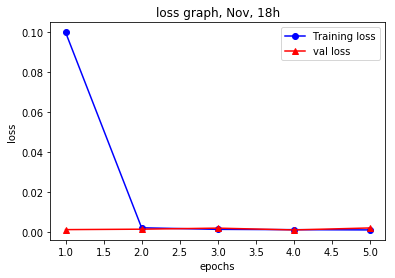

In [80]:
 # 정확도를 위해서는 월별로, 지점별로 테스트 해봐야할것 같다.

hist_dict=hist.history
hist_dict.keys()

val_loss= hist_dict['val_loss']
loss = hist_dict['loss']
epochs =range(1,len(loss)+1)

plt.plot(epochs,loss,'bo-',label='Training loss')
plt.plot(epochs,val_loss,'r^-',label='val loss')

plt.title('loss graph, Nov, 18h')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

In [81]:
np.mean(loss)

0.021181997606364182

In [82]:
np.mean(val_loss)

0.0015764828326857903

In [2514]:
# 월구분,stn구분은 해서 비교표를 결과로 넣을 것

# -----------------------------------------------------------

In [ ]:
# 중간전처리 코드  #15년도의 image folder정리 

In [1014]:
csvfile=pd.read_csv('./y-test.csv',encoding='cp949')
filtered_csv=[]
for i in list(range(0,len(img_val_name))): #img의 날짜를 str ->int 필요함
    temp=csvfile.loc[csvfile['일시']==int(img_val_name[i]),['일사(MJ/m2)']]
    temp=temp.values.tolist()
    filtered_csv.append(temp)


NameError: name 'img_val_name' is not defined

In [161]:
#csvfile['일시'].value_counts()

In [159]:
v_count=csvfile['일시'].value_counts()

In [1008]:
v_count.value_counts()
# denoise.detmp()

NameError: name 'v_count' is not defined